# Monte Carlo Radiative Transfer

## Understanding Photon Propagation Through Random Walks

In this exercise, we'll explore how photons move through matter by implementing **Monte Carlo radiative transfer simulations**. Starting with simple random walks, we'll progressively add physical realism by incorporating:

- **Free path distributions** based on Thomson scattering
- **Optical depth sampling** using inverse transform methods  
- **Statistical analysis** of photon behavior in different media

The key insight: **Monte Carlo methods sample individual photon paths rather than solving differential equations for the radiation field**

We'll build intuition about radiative transfer by tracking energy packets through 2D random walks that mirror real astrophysical processes.

In [2]:
### Execute this first 
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x1181f1a90>

# 2D Random Walk: Packet Motion in a Plane

In Monte Carlo radiative transfer, we don't solve differential equations for intensity — we follow the paths of indivisible energy packets. Each packet represents a bundle of energy and samples its initial direction and frequency from physical distributions.

In this exercise, we build intuition for that idea by simulating a packet as it takes a 2D random walk. This simplified model assumes:

- The packet starts at the origin $(0, 0)$
- Each step has a fixed length
- At every step, the packet picks a new random direction (angle $\theta \in [0, 2\pi]$)

This is a toy model of scattering in a homogeneous, isotropic medium. You'll write a loop that updates the packet's position step by step and visualize its trajectory.

Later, we'll make this more realistic by replacing the fixed step size with one sampled from a physical **mean free path distribution** based on optical depth.

---

### $\blacktriangleright$ Your Task

Complete the missing code in the random walk simulation below:

1. **Generate a random direction** for each step with proper astropy units

2. **Calculate the displacement components** using trigonometry

3. **Update the position arrays** for the current step

The result should show a wandering path that starts at the red dot (origin) and ends at the black dot.

---

<details>
<summary><strong>💡 Hint 1</strong></summary>

Remember that numpy trigonometric functions work with astropy quantities, so you can use:
```python
theta = np.random.uniform(0, 360) * u.degree
delta_x = step_size * np.cos(theta)
```
</details>

<details>
<summary><strong>💡 Hint 2</strong></summary>

The random walk should look like a jagged path. If you see a straight line, check that your angle is being randomized at each step.
</details>

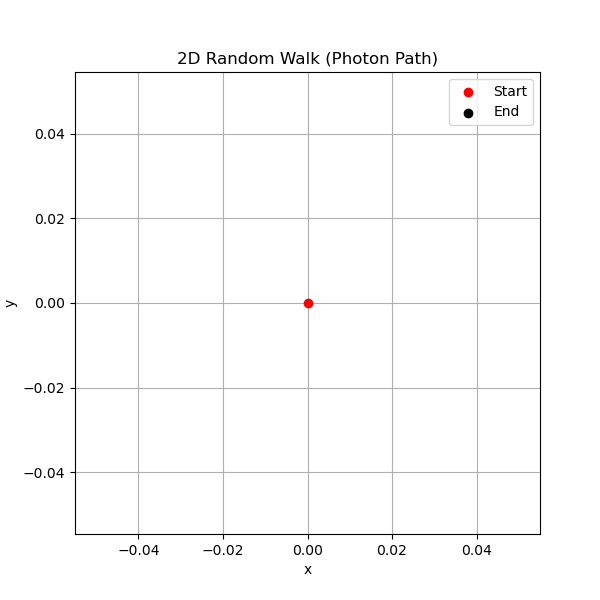

In [3]:
%matplotlib widget

N_STEPS = 200

# Arrays to store positions
x_positions = np.zeros(N_STEPS + 1) * np.nan * u.m
y_positions = np.zeros(N_STEPS + 1) * np.nan * u.m

x_positions[0] = 0.0 * u.m # Starting x position
y_positions[0] = 0.0 * u.m # Starting y position
STEP_SIZE = 1.0 * u.cm
# Perform random walk
for i in range(1, N_STEPS + 1):
    pass
    # draw random direction theta using astropy units
    
    # Update positions x_positions[i] and y_positions[i]

# Plotting the walk
plt.figure(figsize=(6, 6))
plt.plot(x_positions, y_positions, lw=1.5)
plt.scatter([0], [0], color='red', label='Start', zorder=5)
plt.scatter([x_positions[-1]], [y_positions[-1]], color='black', label='End', zorder=5)
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.title("2D Random Walk (Photon Path)")
plt.grid(True)
plt.legend()
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


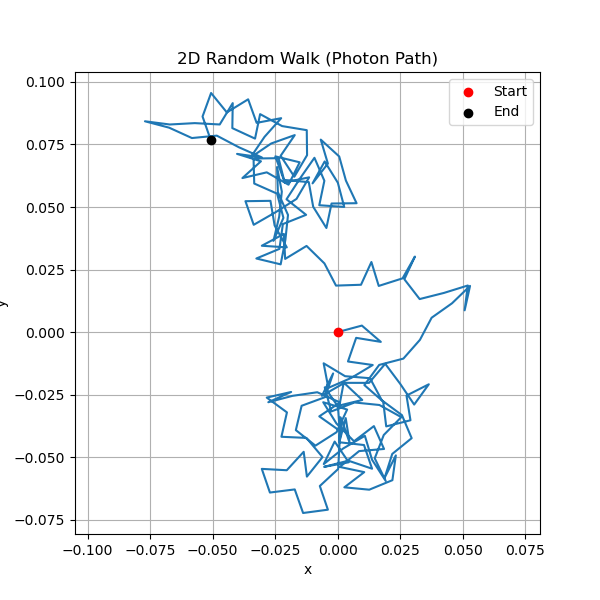

In [4]:
%pylab widget
import numpy as np
import matplotlib.pyplot as plt

N_STEPS = 200

# Arrays to store positions
x_positions = np.zeros(N_STEPS + 1) * np.nan * u.m
y_positions = np.zeros(N_STEPS + 1) * np.nan * u.m

x_positions[0] = 0.0  # Starting x position
y_positions[0] = 0.0  # Starting y position
STEP_SIZE = 1.0 * u.cm
# Perform random walk
for i in range(1, N_STEPS + 1):
    theta = np.random.uniform(0, 360) * u.degree  # random angle in radians
    delta_x = STEP_SIZE * np.cos(theta)
    delta_y = STEP_SIZE * np.sin(theta)
    # Step size = 1 unit in direction theta
    x_positions[i] = x_positions[i - 1] + delta_x  
    y_positions[i] = y_positions[i - 1] + delta_y 

# Plotting the walk
plt.clf()
plt.figure(figsize=(6, 6))
plt.plot(x_positions, y_positions, lw=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.scatter([0], [0], color='red', label='Start', zorder=5)
plt.scatter([x_positions[-1]], [y_positions[-1]], color='black', label='End', zorder=5)

plt.axis("equal")
plt.title("2D Random Walk (Photon Path)")
plt.grid(True)
plt.legend()
plt.show()

# Free Paths and Optical Depth in Thomson Scattering

In our Monte Carlo approach, we track **indivisible energy packets** as they move through matter.  
Here, we model how packets propagate through a fully ionized hydrogen plasma, where **Thomson scattering** dominates.

---

### Physical Background

- As a packet moves through the medium, it may scatter off electrons.
- The **optical depth** $\tau$ quantifies the likelihood of interaction over a distance:

  $$\tau = n_e \sigma_T s$$

  where:
  - $n_e$: electron number density  
  - $\sigma_T$: Thomson scattering cross section  
  - $s$: path length

- The probability that a packet travels at least distance $s$ without interacting is:

  $$P(s) \propto \exp(-n_e \sigma_T s)$$

---

### Monte Carlo Interpretation

In Monte Carlo, we don't fix a step size.  
Instead, we sample a random **optical depth** at which the interaction will occur:

$$\tau_{\text{event}} = -\ln(R), \quad R \sim \mathcal{U}(0, 1)$$

This gives a random stopping point in optical depth.  
We convert it into a physical distance using:

$$\text{distance\_thomson} = \frac{\tau_{\text{event}}}{n_e \sigma_T}$$

This is the distance the packet travels before scattering.

---

### Why This Works: Inverse Transform Sampling

We are sampling from the exponential distribution:

1. The CDF is:

   $$F(\tau) = 1 - \exp(-\tau)$$

2. Let $R \sim \mathcal{U}(0, 1)$, then:

   $$R = F(\tau_{\text{event}}) = 1 - \exp(-\tau_{\text{event}})$$

3. Solving gives:

   $$\tau_{\text{event}} = -\ln(1 - R) \approx -\ln(R)$$

---

### What You'll Do

Simulate a large number of energy packets.  
For each packet:

1. Draw $\tau_{\text{event}}$  
2. Convert to `distance_thomson`  
3. Histogram the free paths

Compare your results to the theoretical exponential distribution.

# Photon Propagation with Physical Step Sizes

In our earlier random walks, the photon took steps of fixed length.  
Now we'll make the simulation **physically realistic** by having photons travel distances drawn from an **exponential distribution of free paths**, based on **Thomson scattering in supernova ejecta**.

---

## $\blacktriangleright$ Your Tasks

Complete the code in the cell below by implementing the following steps:

### 1. **Calculate the mean free path**

Use the physical relationship: $\lambda = \frac{1}{n_e \sigma_T}$

Replace the placeholder value with the correct calculation and convert to appropriate units.

### 2. **Sample physical step sizes using inverse transform sampling**

For each step in the random walk:
- Draw a random number and calculate optical depth using $\tau_{\text{event}} = -\ln(R)$
- Convert to physical distance: $s = \frac{\tau_{\text{event}}}{n_e \sigma_T}$
- Store the step size

### 3. **Update photon positions**

Use trigonometry to calculate displacement components and update the position arrays.

### 4. **Complete the histogram plot**

Add the missing histogram to visualize the step size distribution.

---

### Physical Context

- **Electron number density**: $n_e = 10^9 \text{ cm}^{-3}$ (realistic for supernova ejecta)
- **Thomson cross-section**: Available from `astropy.constants.sigma_T`
- **Mean free path**: The average distance a photon travels before scattering

Print the mean free path in different units to get physical intuition.

---

<details>
<summary><strong>💡 Hint 1</strong></summary>

The mean free path calculation should give you a very large number in cm. This is because Thomson scattering has a small cross-section.
</details>

<details>
<summary><strong>💡 Hint 2</strong></summary>

Your step size histogram should look roughly exponential - most steps are short, with a long tail of occasional large steps.
</details>

In [5]:
# Electron number density (example: hot ionized plasma)
N_E = 1e9 * u.cm**-3

# Mean free path
MEAN_FREE_PATH = -99.0 * u.nm

print(f"Mean free path: {MEAN_FREE_PATH:.2e}")
print(f"Mean free path in AU: {MEAN_FREE_PATH:.2e}")

Mean free path: -9.90e+01 nm
Mean free path in AU: -9.90e+01 nm


<>:45: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\e'
/var/folders/fg/nwmb1mss6kq3hwhj10dt0qh00000gn/T/ipykernel_36297/3960567139.py:45: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(s_vals, pdf, 'r--', label='Theoretical $\exp(-\\tau)$')


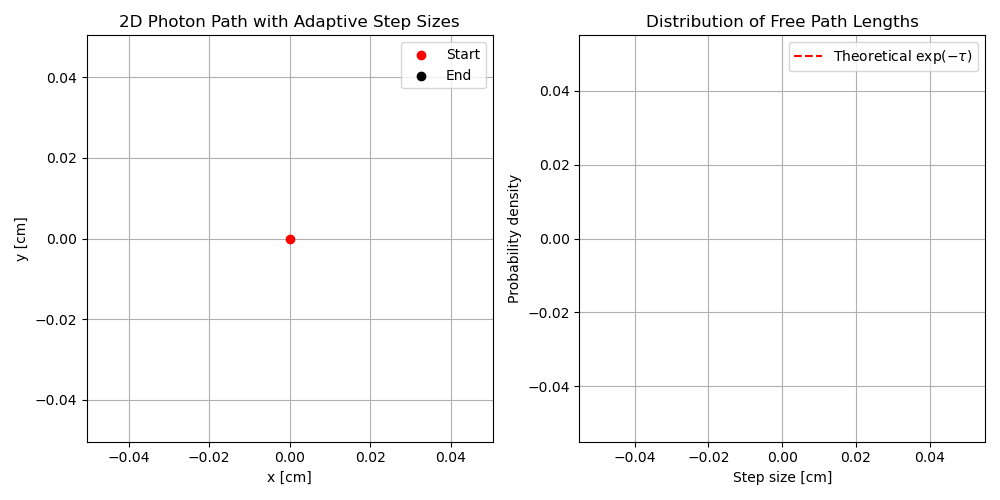

In [20]:
# Number of photons
N_PHOTONS = 200

# Arrays to store positions and distances
x_positions = np.zeros(N_PHOTONS + 1) * np.nan * u.cm
y_positions = np.zeros(N_PHOTONS + 1) * np.nan * u.cm
step_sizes = np.zeros(N_PHOTONS) * u.cm

x_positions[0] = 0.0  # Starting x position
y_positions[0] = 0.0  # Starting y position

# Monte Carlo simulation: photon random walk with adaptive step sizes
for i in range(1, N_PHOTONS + 1):
    pass
    # Sample optical depth using inverse transform sampling
    
    # Convert optical depth to physical step size
    
    # Random direction
    
    # Update positions

# Plotting the walk
plt.figure(figsize=(10, 5))

# Plot 1: Random walk path
plt.subplot(1, 2, 1)
plt.plot(x_positions, y_positions, lw=1.5)
plt.scatter([0], [0], color='red', label='Start', zorder=5)
plt.scatter([x_positions[-1]], [y_positions[-1]], color='black', label='End', zorder=5)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.axis("equal")
plt.title("2D Photon Path with Adaptive Step Sizes")
plt.grid(True)
plt.legend()

# Plot 2: Distribution of step sizes
plt.subplot(1, 2, 2)
# Show the distribution of step sizes

# Plot theoretical exponential curve
s_vals = np.linspace(0, np.max(step_sizes), 500)
pdf = s_vals * np.nan  # complete this (exponential probability density function)
plt.plot(s_vals, pdf, 'r--', label='Theoretical $\exp(-\\tau)$')

plt.xlabel("Step size [cm]")
plt.ylabel("Probability density")
plt.title("Distribution of Free Path Lengths")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Mean free path: 1.50e+15 cm


<>:67: SyntaxWarning: invalid escape sequence '\e'
<>:67: SyntaxWarning: invalid escape sequence '\e'
/var/folders/fg/nwmb1mss6kq3hwhj10dt0qh00000gn/T/ipykernel_36297/2831791481.py:67: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(s_vals, pdf, 'r--', label='Theoretical $\exp(-\\tau)$')


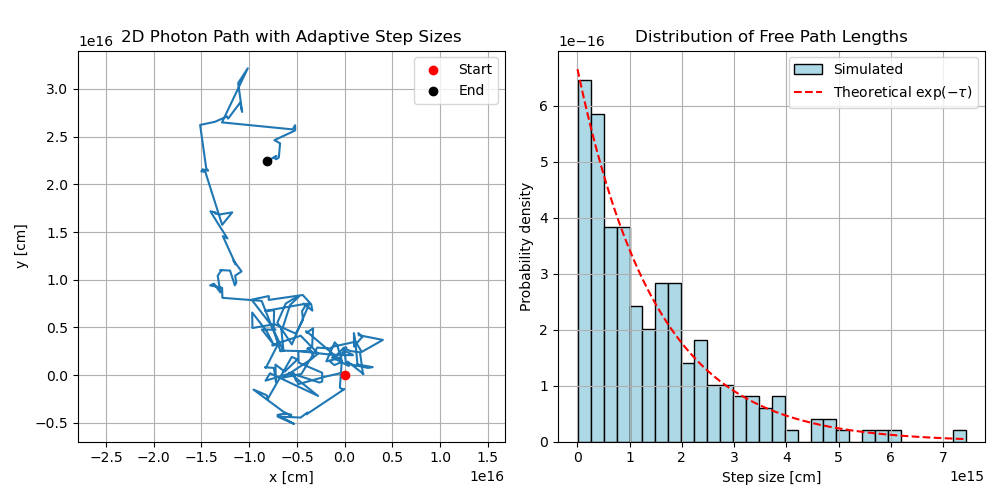

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import sigma_T
import astropy.units as u

# Electron number density (example: hot ionized plasma)
N_E = 1e9 * u.cm**-3

# Mean free path
MEAN_FREE_PATH = 1 / (N_E * sigma_T)
MEAN_FREE_PATH = MEAN_FREE_PATH.to(u.cm)

print(f"Mean free path: {MEAN_FREE_PATH:.2e}")

# Number of photons
N_PHOTONS = 200

# Arrays to store positions and distances
x_positions = np.zeros(N_PHOTONS + 1) * u.cm 
y_positions = np.zeros(N_PHOTONS + 1) * u.cm
step_sizes = np.zeros(N_PHOTONS) * u.cm

x_positions[0] = 0.0  # Starting x position
y_positions[0] = 0.0  # Starting y position

# Monte Carlo simulation: photon random walk with adaptive step sizes
for i in range(1, N_PHOTONS + 1):
    # Sample optical depth using inverse transform sampling
    random_number = np.random.rand()
    tau_event = -np.log(random_number)  
    
    # Convert optical depth to physical step size
    step_size = (tau_event / (N_E * sigma_T))  # complete this (divide tau by n_e * sigma_T and convert to cm)
    step_sizes[i-1] = step_size
    
    # Random direction
    theta = np.random.uniform(0, 2 * np.pi)  # random angle in radians
    delta_x = step_size * np.cos(theta)
    delta_y = step_size * np.sin(theta)
    
    # Update positions
    x_positions[i] = x_positions[i - 1] + delta_x  # complete this
    y_positions[i] = y_positions[i - 1] + delta_y  # complete this

# Plotting the walk
plt.figure(figsize=(10, 5))

# Plot 1: Random walk path
plt.subplot(1, 2, 1)
plt.plot(x_positions, y_positions, lw=1.5)
plt.scatter([0], [0], color='red', label='Start', zorder=5)
plt.scatter([x_positions[-1]], [y_positions[-1]], color='black', label='End', zorder=5)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.axis("equal")
plt.title("2D Photon Path with Adaptive Step Sizes")
plt.grid(True)
plt.legend()

# Plot 2: Distribution of step sizes
plt.subplot(1, 2, 2)
plt.hist(step_sizes.value, bins=30, density=True, color='lightblue', edgecolor='black', label='Simulated')

# Plot theoretical exponential curve
s_vals = np.linspace(0, np.max(step_sizes), 500)
pdf = (1 / MEAN_FREE_PATH) * np.exp(-s_vals / MEAN_FREE_PATH)  # complete this (exponential probability density function)
plt.plot(s_vals, pdf, 'r--', label='Theoretical $\exp(-\\tau)$')

plt.xlabel("Step size [cm]")
plt.ylabel("Probability density")
plt.title("Distribution of Free Path Lengths")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# How Far Do Typical Photons Typically Travel?

Now that you've computed **step sizes** in physical units, let's examine how far photons typically travel in **optical depth units**.

This analysis will help you understand the difference between **mean** and **median** in exponential distributions — a key concept in radiative transfer.

---

## $\blacktriangleright$ Your Task

Complete the code in the cell below to analyze the optical depth distribution:

### 1. **Convert step sizes to optical depths**

Use the relationship: $\tau = n_e \sigma_T s$

### 2. **Calculate statistical measures**

Compute both the mean and median optical depths.

### 3. **Normalize by the mean free path** (Optional)

Calculate the ratios in terms of mean free path lengths for additional insight.

---

## Discussion Questions

After calculating both values, consider:

1. **If the mean optical depth is close to 1, does that mean half of the photons travel more than one optical depth?**

2. **What does the median optical depth tell you about what's "typical"?**

3. **Why might the median be more representative of typical photon behavior than the mean?**

---

<details>
<summary><strong>Physical Insight Hint</strong></summary>

We're often intuitively biased by **Gaussian distributions**, where the **mean** and **median** are the same.

But in this case — an **exponential distribution** — that's not true:

- The **mean optical depth** $\langle \tau \rangle = 1$
- The **median optical depth** $\tilde{\tau} \approx \ln(2) \approx 0.693$

This means:
> **50% of photons travel less than $\tau \approx 0.693$, and 50% travel more.**

This is why you'll often hear:
> "*a photon typically travels about 2/3 of an optical depth before interacting*"

Even though the average is 1, the **median** better captures what's typical in many physical scenarios.

</details>

---

<details>
<summary><strong>Hint</strong></summary>

Your calculation should show that the mean optical depth is approximately 1.0, while the median is around 0.693. This is a fundamental property of the exponential distribution used in Monte Carlo radiative transfer.
</details>

In [22]:
#calculate both mean and median and normalize with the mean free path length

In [23]:
np.mean(step_sizes)/MEAN_FREE_PATH, np.median(step_sizes)/MEAN_FREE_PATH

(<Quantity 0.9541253>, <Quantity 0.67496718>)

## Summary: From Random Walks to Physical Radiative Transfer

In this notebook, we developed Monte Carlo radiative transfer by progressing from simple random walks to physically realistic photon propagation through Thomson scattering media.

### Implementation Highlights

**Monte Carlo Philosophy**
- Track individual energy packets rather than solve differential equations
- Sample photon paths stochastically using inverse transform sampling
- Build physical realism through exponential free path distributions

**Physical Pipeline**
1. **Basic Random Walk**: Fixed step sizes with random directions
2. **Thomson Scattering**: Electron-photon interactions via $\sigma_T = 6.652 \times 10^{-25}\,\text{cm}^2$
3. **Optical Depth Sampling**: $\tau_{\text{event}} = -\ln(R)$ where $R \sim \mathcal{U}(0,1)$
4. **Physical Distances**: $s = \tau_{\text{event}}/(n_e \sigma_T)$

### Key Physical Insights

**Mean Free Path**: $\lambda = (n_e \sigma_T)^{-1} \sim 10^{14}\,\text{cm}$ for $n_e = 10^9\,\text{cm}^{-3}$

**Exponential Distribution Properties**
- Mean optical depth: $\langle\tau\rangle = 1$
- Median optical depth: $\tilde{\tau} \approx 0.693$
- **Physical interpretation**: 50% of photons scatter **before** traveling one optical depth


### Forward Connections

**Supernova Modeling**
- Expanding ejecta create velocity-dependent optical depths
- Photosphere defined where $\tau \sim 1$
- Multiple scattering events build emergent spectra

This framework demonstrates how stochastic sampling captures radiative transfer physics, providing computational tractability and physical insight into photon transport through astrophysical media.

In [26]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']
    
nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --ClearOutputPreprocessor.enabled=True --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")

[NbConvertApp] Converting notebook 2_mc_radiative_transfer_random_walk_instructor.ipynb to notebook
[NbConvertApp] Writing 16410 bytes to 2_mc_radiative_transfer_random_walk_student.ipynb
Converted 2_mc_radiative_transfer_random_walk_instructor.ipynb to 2_mc_radiative_transfer_random_walk_student.ipynb
